# Tarea 5

Autor: Emmanuel A. Larralde Ortiz

## Resumen

En este trabajo vemos como maximizar/minimizar una función puede funcionar para generar una función de clasificación. Más particularmente, se maximiza una función de costo relacionada con la entropía cruzada de una regresión logística utilizada para clasificar `1s` y `0s` del conjunto de datos de números escritos a mano `MNIST`, y usando `Steepest gradient descent` con tamaño de paso fijo y `Backtracking` para resolver el problema de optimización.

## Instalación

Si ya cuentas con python y las librerías de numpy y matplotlib, omite esa sección.

1. (Recomendado pero no necesario) Crea un ambiente virtual:
   
```sh
pip install virtualenv    
python -m venv .env
source .env/bin/activate
```

2. Instala las librerías

```sh
pip install -r requirements.txt
```

## Introducción

Como se ha visto anteriormente, el algoritmo de descenso de gradiente es un algoritmo de optimización sin restricciones de búsqueda en lineal (asume una aproximación lineal en la vecindad) interesado en resolver un problema de minimizar $f(x)$ con $x \in R^n$, donde $f(x)$ es una función diferenciable. Si $x = \bar{x}$ es un punto dado, $f(x)$ puede ser aproximado de forma lineal usando una serie de Taylor:

\begin{align}
    f(\bar x + d) \approx f(\bar x) + \nabla f(\bar x )^T d
\end{align}

Si $||d||$ es pequeño.

Y se puede demostrar que la dirección de descenso más "empinada" es $d = - \nabla f(\bar x) = -g(\bar x)$.

Recordemos que el algoritmo es iterativo, donde dado una aproximación inicial $x_0$, se buscará una mejor $x_k$ tal que minimice $f(x_k)$. La forma de actualizar la estimación es la siguiente:

$$
x_{k+1} = x_k + \alpha_k d_k
$$


Donde $d_k$ es una dirección de descenso tal que $d_k^Tg(x_k) = -1$ y $\alpha_k$ es una estimación del tamaño de paso, y se había mencionado que se obtiene al resolver $min_{\alpha} f(x_k + \alpha d_k)$ con una búsqueda lineal. Sin embargo, no es necesario obtener un valor exacto del mejor tamaño de paso. Podemos usar el siguiente *tradeoff*: seleccionar $\alpha_k$ que de una reducción suficiente de $f$, y al mismo tiempo, hacerlo de manera eficiente.

Una forma de seleccionar el tamaño de paso es calculando el optimizador global de $\phi(\alpha) = f(x_k + \alpha d_k)$, i.e.,

\begin{align*}
    \alpha_k = \arg \min_{\alpha > 0} \phi(\alpha)
\end{align*}

O usando aproximaciones (como en la tarea 3). Pero inclusive un tamaño de paso fijo es suficiente para reducir $f$ en muchas iteraciones hasta obtener una solución satisfactoria. Unn nuevo método para calcular $\alpha_k$ utilizado en este trabajo es `Backtracking`. El algoritmo se muestra a continuación.

> #### Backtracking
> 
> Let $\hat{\alpha} > 0$, $\rho \in (0, 1)$, $c_1 \in (0, 1)$\
> $\alpha \leftarrow \hat \alpha$\
> while $f(x_k + \alpha d_k) \leq f(x_k) + c_1 \alpha \nabla f_k^T d_k$:
>> $\alpha \leftarrow \rho\alpha$
> 
> return $\alpha$

Y el algortimo de descenso de gradiente con `Backtracking` queda como se muestra a continuación:

> ##### Descenso de gradiente con backtracking
> 
> Let $\tau > 0$\
> $d \leftarrow -g(x)$\
> while $||g|| \geq \tau$:
>> $\alpha = \text{backtracking()}$\
>> $x \leftarrow x + \alpha d$\
>> $d \leftarrow -g(x)$
>
> retrun $x$

### Sobre el ejercicio

Maximize the function $h(\beta, \beta_0)$ defined below with respect to $\beta, \beta_0$ using the
steepest descent algorithm.

\begin{align*}
    h(\beta, \beta_0) &= \sum_{i=1}^n y_i \log \pi_i + (1 - y_i)log(1 - \pi_i)\\
    \pi_i := \pi(\beta, \beta_0) &= \frac{1}{1 + \exp(-x_i^T\beta - \beta_0)}
\end{align*}

Vemos que $0 \leq \pi \leq 1$, y consideramos que $y \in \{0, 1\}$, entonces, podemos interpretar $y_i$ y $\pi_i$ como probabilidades y el término $y_i \log \pi_i + (1 - y_i)log(1 - \pi_i)$ es la entropía cruzada de dos distribuciones Bernoulli con medias $p_i$ y $\pi_i$, respectivamente. A continucación veremos que sucede con la entropía cruzada con diferentes valores $y_i, \pi_i$: 

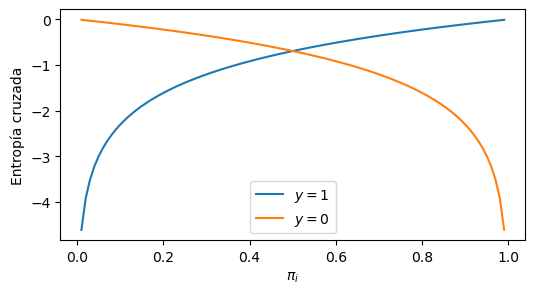

In [1]:
import numpy as np
import matplotlib.pyplot as plt

cross_entropy = lambda y, pi: y*np.log(pi) + (1 - y)*np.log(1 - pi)
pis = np.linspace(0.01, 0.99, 100)
plt.figure(figsize=(6, 3))
plt.plot(pis, cross_entropy(1, pis), label='$y = 1$')
plt.plot(pis, cross_entropy(0, pis), label='$y = 0$')
plt.xlabel('$\\pi_i$')
plt.ylabel('Entropía cruzada')
plt.legend()
plt.show()

En términos generales, se observa que $y_i \log \pi_i + (1 - y_i)log(1 - \pi_i)$ se maximiza cuando $\pi_i$ se acerca a $y_i$. Entonces, $h$ se maximiza cuando todas las predicciones $\pi_i$ se acercan a los valores reales $y_i$. Por lo tanto, optimizar $h$ consiste en construir un clasificador $\pi_i$

## Resultados

Definimos un nuevo parámetro $\omega$ tal que $\omega = [\beta^T, \beta_0]^T$ y otras coordenadas para las muestras $z$ tal que $z_i = [x_i^T, 1]^T$, de esta forma $x_i^T\beta + \beta_0 = z_i^T\omega$. Ahora trataremos de encontrar el parámetro $\omega^*$ que maximice $h(\omega)$. Finalmente, para utilizar los esquemas vistos anteriormente, en lugar de maximizar una función buscaremos minimizar otra. Maximizar $h(\omega)$ es equivalente a minimizar $-h(\omega)$.

Calculamos el gradiente de $h(\omega)$ para obtener la dirección de descenso.

\begin{align*}
    \frac{\partial h}{\partial \omega_j} &= \sum_{i=1}^n \frac{\partial h}{\partial \pi_i} \cdot  \frac{\partial \pi_i}{\partial v_i} \cdot \frac{\partial v_i}{\partial \omega_j} &\text{$v_i = z_i^T \omega$}\\
                                        &= \sum_{i=1}^n \frac{y_i - \pi_i}{\pi_i(1 - \pi_i)} \cdot \pi_i(1 - \pi_i) \cdot z_{ij} \\                                        &= \sum_{i=1}^n (y_i - \pi_i) z_{ij} \\
                                       \nabla h(\omega) &= \sum_{i=1}^n (y_i - \pi_i) z_i = z(y - \pi) &\text{Maximización} \\
                                       -\nabla h(\omega) &= \sum_{i=1}^n (\pi_i - y_i) z_i = z(\pi - y) & \text{Minimización}
\end{align*}

En el archivo `src/logistic.py` puedes encontrar la implementación de la implementación de $-\nabla h(\omega)$. Nótese que la impolementación de la función sigmoide

```python
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1 + np.exp(-np.clip(x, -10, 10)))
```

está definida en el dominio $[-10, 10]$. Se hace de esta forma para evitar que numéricamente nunca calcule un $0$ o un $1$ como respuesta y así evitar indetermincaciones al calcular la entropía cruzada.

Los algoritmos de descenso de gradiente con tamaño de paso constante y con *backtracking* se encuentran en `src/optim.py`.

Finalmente, a continuación se muestran los resultados numéricos.

In [2]:
# 1. Cargamos los datos
from src.datasets import load_digits
import numpy as np

def get_zeros_ones(dataset_set):
    x, y = dataset_set
    idcs = np.argwhere(np.isin(y, [0, 1]))
    n = len(idcs)
    return (x[idcs].reshape(n, -1), y[idcs].flatten())

dataset = load_digits()
train_x, train_y = get_zeros_ones(dataset.train)

Para acelerar un poco el proceso, seleccionaremos un subconjunto de datos del conjunto de datos de entrenamiento

In [3]:
import random

n_sample = 500
pairs = list(zip(train_x, train_y))
pairs = random.sample(pairs, n_sample)
train_x, train_y = zip(*pairs)
train_x = np.array(train_x)
train_y = np.array(train_y)

### Optimización con tamaño de paso constante

In [4]:
# 2. Entrenamos un modelo con tamaño de paso constante
from src.logistic import LogisticRegression
from src.optim import FixedSteepestDescent

fixed_step_model = LogisticRegression(train_x.shape[1])
fixed_step_history = fixed_step_model.train(
    train_x,
    train_y,
    FixedSteepestDescent,
    alpha=0.001,
    tf=1e-6,
    tx=1e-6,
    epochs=10000
)

### Optimización con tamaño de paso obtenido por *backtracking*

In [5]:
# 3. Entrenamos un modelo con tamaño de paso seleccionado con backtraking
from src.optim import Backtracking

backtracking_model = LogisticRegression(train_x.shape[1])
backtracking_history = backtracking_model.train(
    train_x,
    train_y,
    Backtracking,
    alpha_0=0.001,
    rho=0.5,
    c1=0.1,
    tau = 0.05,
    epochs=10000,
)

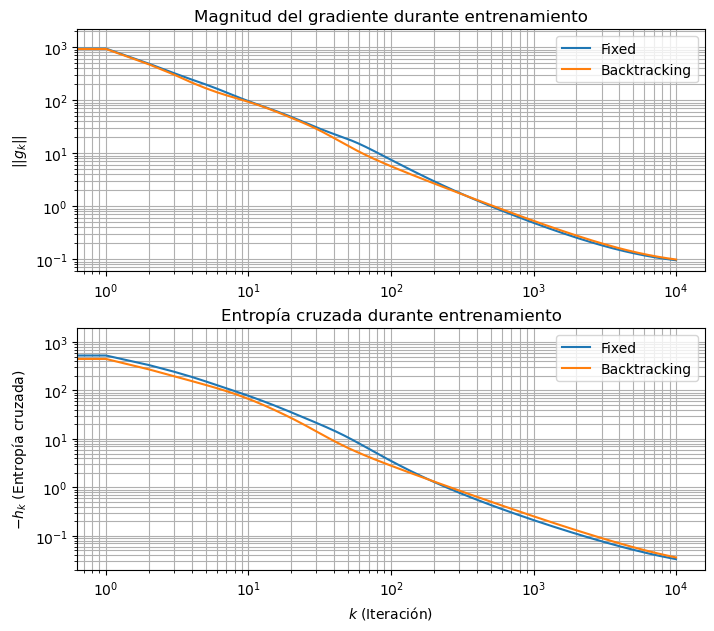

In [6]:
#4. Mostramos los resultados
# 4.1 Gráfica del gradiente

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))
fig.tight_layout(h_pad = 2)

axs[0].loglog(fixed_step_history['grad_norm'], label='Fixed')
axs[0].loglog(backtracking_history['grad_norm'], label='Backtracking')
axs[0].legend()
axs[0].grid(True, which="both")
axs[0].set_title("Magnitud del gradiente durante entrenamiento")
axs[0].set_ylabel("$||g_k||$")

axs[1].loglog(fixed_step_history['loss'], label='Fixed')
axs[1].loglog(backtracking_history['loss'], label='Backtracking')
axs[1].legend()
axs[1].grid(True, which="both")
axs[1].set_title("Entropía cruzada durante entrenamiento")
axs[1].set_xlabel("$k$ (Iteración)")
axs[1].set_ylabel("$-h_k$ (Entropía cruzada)")

plt.show()

Finalmente, evaluaremos el error de ambos clasificadores. El error se calcula como se muestra a continuación:

\begin{align*}
    \text{error} = \frac{1}{n} \sum_{i=1}^n |1_{\pi_i > 0.5}(x_i) - y_i|
\end{align*}

Con $1_{\pi_i>0.5}(x_i) = 1$ cuando $\pi(x_i) > 0.5$ y $1_{\pi_i>0.5} = 0$ en caso contrario.

In [7]:
test_x, test_y = get_zeros_ones(dataset.test)
fixed_step_model_error = fixed_step_model.eval(test_x, test_y)
backtracking_model_error = backtracking_model.eval(test_x, test_y)
print(f"Error del modelo con paso fijo: {fixed_step_model_error}")
print(f"Error del modelo con backtracking: {backtracking_model_error}")

Error del modelo con paso fijo: 0.00425531914893617
Error del modelo con backtracking: 0.003309692671394799


Por último, se muestran algunos de los números del *dataset* y el valor predicho por ambos clasificadores usando la nomenclatura "predicción con tamaño de paso fijo/predicción con tamaño de paso por backtracking".

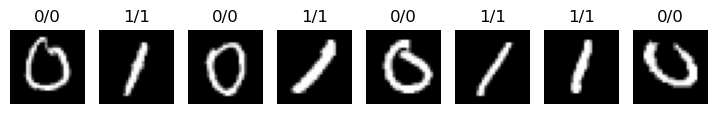

In [8]:
n = 8
index = np.random.choice(test_x.shape[0], n, replace=False)
sub_test_x = test_x[list(index)]

fig, axs = plt.subplots(nrows=1, ncols=n, figsize=(9, 4))
fixed_predict = fixed_step_model.predict(sub_test_x).astype('int')
back_tracking_predict = backtracking_model.predict(sub_test_x).astype('int')
for ax, sample_x, f_predict, b_predict in zip(axs, sub_test_x, fixed_predict, back_tracking_predict):
    ax.axis('off')
    ax.imshow(sample_x.reshape(28, 28), cmap='grey')
    ax.set_title(f"{f_predict}/{b_predict}")

## Conclusiones

Dado a los resultados obtenidos, si se exigen tolerancias muy pequeñas con muchas iteraciones se consiguen resultados con error nulo en el conjunto de prueba. Esto nos da indicios de que los *0s* y *1s* son separables y existe un mínimo global para todo el conjunto de datos de dígitos escritos a mano. No hay certeza de esta afirmación, pero de forma experimental se encuentra que inclusive usando una cantidad reducida del conjunto de entrenamiento es suficiente para encontrar resultados similares en el conjunto de prueba que los obtenidos usando el conjunto de entrenamiento completo. Por último, también se puede resaltar que en efecto el método de *backtracking* con descenso de gradiente es tan efectivo como la selección de un paso fijo para resolver este problema de clasificación. Aunque, sería interesante evaluar cuando un tamaño de paso fijo es más conveniente si existen mínimos locales muy alejados de un mínimo global.